## Instructions
To use this file, please do the following:
1.   Run the script under imports
2.   Run the first script in Getting Data
3.   Modify the DEEPPCB_PCBDATA_DIR variable in the following script to point to the location of the PCBData directory in the DeepPCB dataset.
4.   Run the script containing the DEEPPCB_PCBDATA_DIR variable
5.   Run the second script (the script containing the function gen_model2()) under the Model section.
6.   Run the second script (the one that calls gen_model2()) in the Compile and Fit section.
7.   Run the scripts in Observing Outputs after reading each of their respective instructions.



## Imports

Packages needed for the project

In [ ]:
import numpy as np
import os
import re
import cv2 as cv
from google.colab.patches import cv2_imshow

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models

## Getting Data

This function cuts incoming images into smaller images in order to have more training data.

In [ ]:
DIVISIONS_WIDTH = 2
DIVISIONS_HEIGHT = 2

IMAGE_HEIGHT = 640
IMAGE_WIDTH = 640

smaller_image_height = IMAGE_HEIGHT // DIVISIONS_HEIGHT
smaller_image_width = IMAGE_WIDTH // DIVISIONS_WIDTH

def fix_data(filename):
  im = cv.imread(filename)

  gray_im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)

  _, threshold_im = cv.threshold(gray_im, 127, 255, cv.THRESH_BINARY)

  finished_data = threshold_im // 255

  finished_data_split = []

  split1 = np.split(finished_data, list(range(smaller_image_height, IMAGE_HEIGHT, smaller_image_height)), axis=0)
  split2 = []

  for block in split1:
    split2.append(np.split(block, list(range(smaller_image_width, IMAGE_WIDTH, smaller_image_width)), axis=1))

  for ax1 in np.asarray(split2):
    for ax2 in ax1:
      finished_data_split.append(ax2)

  return finished_data_split

Extracting files from google drive.

In [ ]:
DEEPPCB_PCBDATA_DIR = "/content/drive/MyDrive/ENEE439D Project/PCBData"
#NEW_DATASET_DIR = "/content/drive/MyDrive/ENEE439D Project/AutoencodedData"

groups = ["00041", "12000", "12100", "12300", "13000", "20085", "44000", "50600", "77000", "90100", "92000"]
#groups = ["00041", "12000", "12100", "12300", "13000"]
#groups = ["12000"]
#groups = ["00041"]

train_data = []
train_labels = []

test_data = []
test_labels = []

for group in groups:
  image_file_group = os.listdir(f"{DEEPPCB_PCBDATA_DIR}/group{group}/{group}")
  templates = []
  tests = []

  test_pattern = re.compile(".*test.*")

  number_pattern = re.compile(f".*{group}(\d\d\d)")

  for idx, filename in enumerate(image_file_group):
    if test_pattern.match(filename):
      tests.append(f"{DEEPPCB_PCBDATA_DIR}/group{group}/{group}/{filename}")
    else:
      templates.append(f"{DEEPPCB_PCBDATA_DIR}/group{group}/{group}/{filename}")

  templates.sort()
  tests.sort()

  for idx, sample in enumerate(tests):
    if idx % 5 == 0:
      test_data += fix_data(sample)
    else:
      train_data += fix_data(sample)

  for idx, sample in enumerate(templates):
    if idx % 5 == 0:
      test_labels += fix_data(sample)
    else:
      train_labels += fix_data(sample)

train_len = len(train_data)
test_len = len(test_data)

train_data = np.asarray(train_data)
train_labels = np.asarray(train_labels)
test_data = np.asarray(test_data)
test_labels = np.asarray(test_labels)

train_data = np.reshape(train_data, (train_len, smaller_image_width, smaller_image_height, 1))
train_labels = np.reshape(train_labels, (train_len, smaller_image_width, smaller_image_height, 1))
test_data = np.reshape(test_data, (test_len, smaller_image_width, smaller_image_height, 1))
test_labels = np.reshape(test_labels, (test_len, smaller_image_width, smaller_image_height, 1))

## Model

https://keras.io/examples/vision/autoencoder/

This model was a first look at an auto-encoder but did not end up getting used in the final design.

In [ ]:
def gen_model(rep_size=400):
  model = models.Sequential()

  # Encoder
  model.add(layers.InputLayer(image_shape))
  model.add(layers.Conv2D(32, 3, padding="same", activation="relu"))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, 3, padding="same", activation="relu"))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(rep_size))

  # Decoder
  model.add(layers.Dense(smaller_image_height * smaller_image_width * 4))
  model.add(layers.Reshape((smaller_image_height // 4, smaller_image_width // 4, 64)))
  model.add(layers.Conv2DTranspose(64, 3, padding="same", strides=2, activation="relu"))
  model.add(layers.Conv2DTranspose(32, 3, padding="same", strides=2, activation="relu"))
  #model.add(layers.Conv2D(1, 3, padding="same", strides=(2, 2), activation="softmax"))

  return model

gen_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 160, 160, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 80, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 40, 40, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 102400)            0         
                                                                 
 dense (Dense)               (None, 400)               4

This design is the final auto-encoded design we used.

In [ ]:
image_shape = (smaller_image_height, smaller_image_width, 1)

# Taken from https://ai.plainenglish.io/convolutional-autoencoders-cae-with-tensorflow-97e8d8859cbe

def gen_model2(rep_size=400):
  # Encoder

  encoder = models.Sequential()

  encoder.add(layers.InputLayer(image_shape))
  encoder.add(layers.Conv2D(32, 3, strides=1, padding='same', activation='relu'))
  encoder.add(layers.MaxPooling2D(2, strides=2))
  encoder.add(layers.Conv2D(64, 3, strides=1, padding='same', activation='relu'))
  encoder.add(layers.MaxPooling2D(2, strides=2))
  encoder.add(layers.Conv2D(128, 3, strides=1, padding='same', activation='relu'))
  encoder.add(layers.MaxPooling2D(2, strides=2))

  # Decoder

  decoder = models.Sequential()

  decoder.add(layers.InputLayer(encoder.output.shape[1:]))
  decoder.add(layers.Conv2D(128, 3, strides=1, padding="same", activation="relu"))
  decoder.add(layers.UpSampling2D(2))
  decoder.add(layers.Conv2D(16, 3, strides=1, padding="same", activation="relu"))
  decoder.add(layers.UpSampling2D(2))
  decoder.add(layers.Conv2D(1, 3, strides=1, padding="same", activation="relu"))
  decoder.add(layers.UpSampling2D(2))

  autoencoder = models.Model(inputs=encoder.input, outputs=decoder(encoder.outputs))

  return autoencoder

gen_model2()


## Compile and Fit

Compiling and fitting the first model.


In [ ]:
model = gen_model()

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
results = model.fit(train_data, train_labels, validation_data=(test_data, test_labels), epochs=50) 

Epoch 1/50
88/88 [==============================] - 21s 226ms/step - loss: 1.6378 - accuracy: 0.0322 - val_loss: 0.6701 - val_accuracy: 0.0383
Epoch 2/50
88/88 [==============================] - 19s 212ms/step - loss: 0.5531 - accuracy: 0.0480 - val_loss: 0.4374 - val_accuracy: 0.0430
Epoch 3/50
88/88 [==============================] - 19s 212ms/step - loss: 0.3796 - accuracy: 0.0436 - val_loss: 0.3225 - val_accuracy: 0.0377
Epoch 4/50
88/88 [==============================] - 19s 213ms/step - loss: 0.2890 - accuracy: 0.0333 - val_loss: 0.2842 - val_accuracy: 0.0263
Epoch 5/50
88/88 [==============================] - 19s 213ms/step - loss: 0.2444 - accuracy: 0.0254 - val_loss: 0.2482 - val_accuracy: 0.0331
Epoch 6/50
88/88 [==============================] - 19s 212ms/step - loss: 0.2174 - accuracy: 0.0250 - val_loss: 0.2359 - val_accuracy: 0.0230
Epoch 7/50
88/88 [==============================] - 19s 212ms/step - loss: 0.2073 - accuracy: 0.0270 - val_loss: 0.2052 - val_accuracy: 0.0288

KeyboardInterrupt: ignored

Compiling and fitting the second model (this is the final design).

In [ ]:
model = gen_model2()

model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
results = model.fit(train_data, train_labels, validation_data=(test_data, test_labels), epochs=50) 

Epoch 1/50
150/150 [==============================] - 1328s 9s/step - loss: 0.0337 - accuracy: 0.9568 - val_loss: 0.0180 - val_accuracy: 0.9767
Epoch 2/50
 67/150 [============>.................] - ETA: 11:29 - loss: 0.0171 - accuracy: 0.9778

KeyboardInterrupt: ignored

## Observing Outputs
Here we see the reconstructed defective images with the test images.

### Instructions
1.  modify the AUTOENCODED_IMAGES_SAMPLES_DIR path to point to a folder where you want your reconstructed images to be saved.
2.  Run the script.

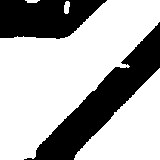

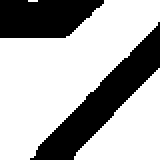

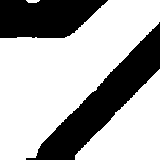

True

In [ ]:
AUTOENCODED_IMAGES_SAMPLES_DIR = "/content/drive/MyDrive/ENEE439D Project/AutoencodedImages/samples"

sample_num = 100

#np.shape(test_data[0])
result = model.predict(np.reshape(test_data[sample_num], (1, 160, 160, 1)))[0]
result *= 255

_, result = cv.threshold(result, 127, 255, cv.THRESH_BINARY)

cv2_imshow(test_data[sample_num] * 255)
print("")
cv2_imshow(result)
print("")
cv2_imshow(test_labels[sample_num] * 255)

cv.imwrite(f"{AUTOENCODED_IMAGES_SAMPLES_DIR}/{sample_num}_test.png", test_data[sample_num] * 255)
cv.imwrite(f"{AUTOENCODED_IMAGES_SAMPLES_DIR}/{sample_num}_result.png", result)
cv.imwrite(f"{AUTOENCODED_IMAGES_SAMPLES_DIR}/{sample_num}_temp.png", test_labels[sample_num] * 255)

Attempting to stitch together multiple auto-encoded images to reproduce the original.
### Instructions
1.  Modify the TEST_IMAGE_PATH variable to point to a defective image.
2.  Modify the TEMPLATE_IMAGE_PATH variable to point to the corresponding template image.
3.  Modify the OUTPUT_IMAGE_PATH variable to be the file name of the output image.
4.  Run the script.

(4, 4, 160, 160, 1)


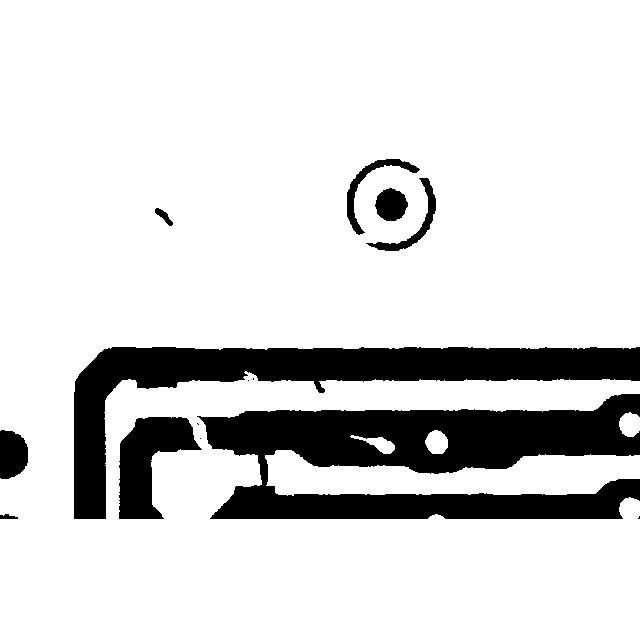

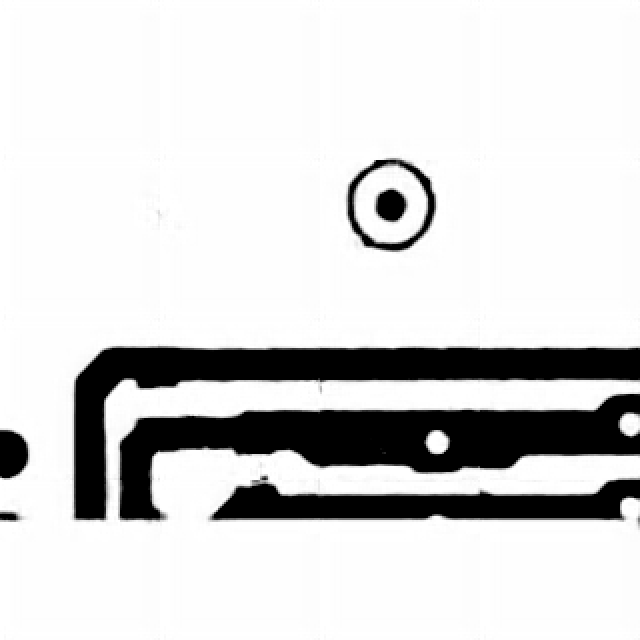

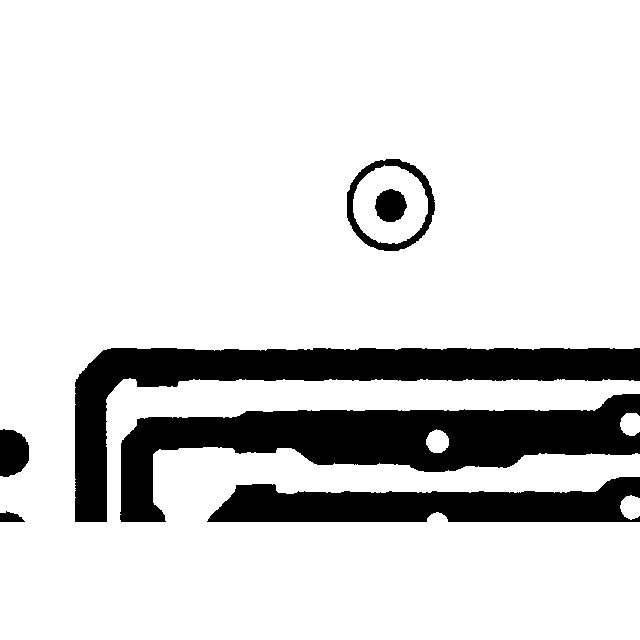

True

In [ ]:
TEST_IMAGE_PATH = "/content/drive/MyDrive/ENEE439D Project/PCBData/group00041/00041/00041016_test.jpg"
TEMPLATE_IMAGE_PATH = "/content/drive/MyDrive/ENEE439D Project/PCBData/group00041/00041/00041016_temp.jpg"
OUTPUT_IMAGE_PATH = "/content/drive/MyDrive/ENEE439D Project/AutoencodedImages/00041016.png"

group = "00041"

template = TEMPLATE_IMAGE_PATH
test = TEMPLATE_IMAGE_PATH

template_array = cv.imread(template)
test_array = cv.imread(test)

image_data = fix_data(test)

new_image = [[] for _ in range(4)]

for idx, segment in enumerate(image_data):
  new_image[idx // 4].append(255 * model.predict(np.reshape(segment, (1, smaller_image_height, smaller_image_width, 1)))[0])

new_image = np.asarray(new_image)

print(np.shape(new_image))

full_image = np.array((0, 640, 1))

row1 = np.concatenate((new_image[0][0], new_image[0][1], new_image[0][2], new_image[0][3]), axis=1)
row2 = np.concatenate((new_image[1][0], new_image[1][1], new_image[1][2], new_image[1][3]), axis=1)
row3 = np.concatenate((new_image[2][0], new_image[2][1], new_image[2][2], new_image[2][3]), axis=1)
row4 = np.concatenate((new_image[3][0], new_image[3][1], new_image[3][2], new_image[3][3]), axis=1)

processed_image = np.concatenate((row1, row2, row3, row4), axis=0)

cv2_imshow(test_array)
print("")
cv2_imshow(processed_image)
print("")
cv2_imshow(template_array)

cv.imwrite(OUTPUT_IMAGE_PATH, processed_image)